# NSL Notebook 07

## Exercise 07.1.1


In [1]:
######                        #######
##  IMPORT DEFAULT PKGS and VARS   ##
######                        #######

from default import *

In [3]:
from itertools import cycle
df = dict()
yy = dict()
states = ["solid", "liquid", "gas"]
vv = ['P', 'V']
cc = cycle("rb")

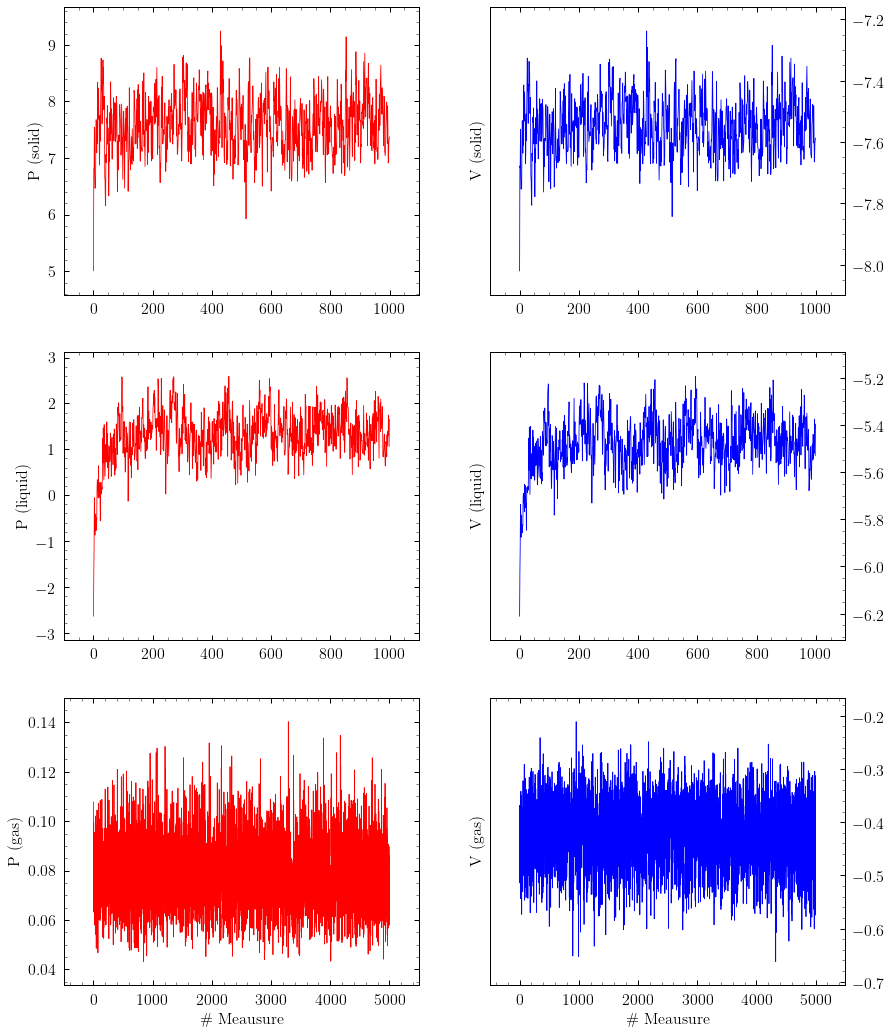

In [2]:
# load equilibrium oscillation
for state in states:
    df[state] = dict()
    dfa = pd.read_csv(f"th-{state}.tsv", header=None, sep='\t', names=['P', 'V'])
    for v in vv:
         df[state][v] = dfa[v]
            
for v in vv:
    df["solid"][v] = df["solid"][v][:1000]
    df["liquid"][v] = df["liquid"][v][:1000]
    df["gas"][v] = df["gas"][v][:5000]
        

fig, ax = plt.subplots(3, 2, figsize=(14,18));
ax = np.asarray(ax)
ax.shape = (1,6)
ax = ax[0]

ix=0
for state in states:
    for v in vv:
        df[state][v].plot.line(c=next(cc), lw=0.8, ax=ax[ix]);
        ax[ix].yaxis.tick_right() if (ix+1) % 2 == 0 else 0
        ax[ix].set_ylabel(f"{v} ({state})");
        ix += 1
    
ax[4].set_xlabel("\# Meausure");
ax[5].set_xlabel("\# Meausure");

## Exercise 07.1.2

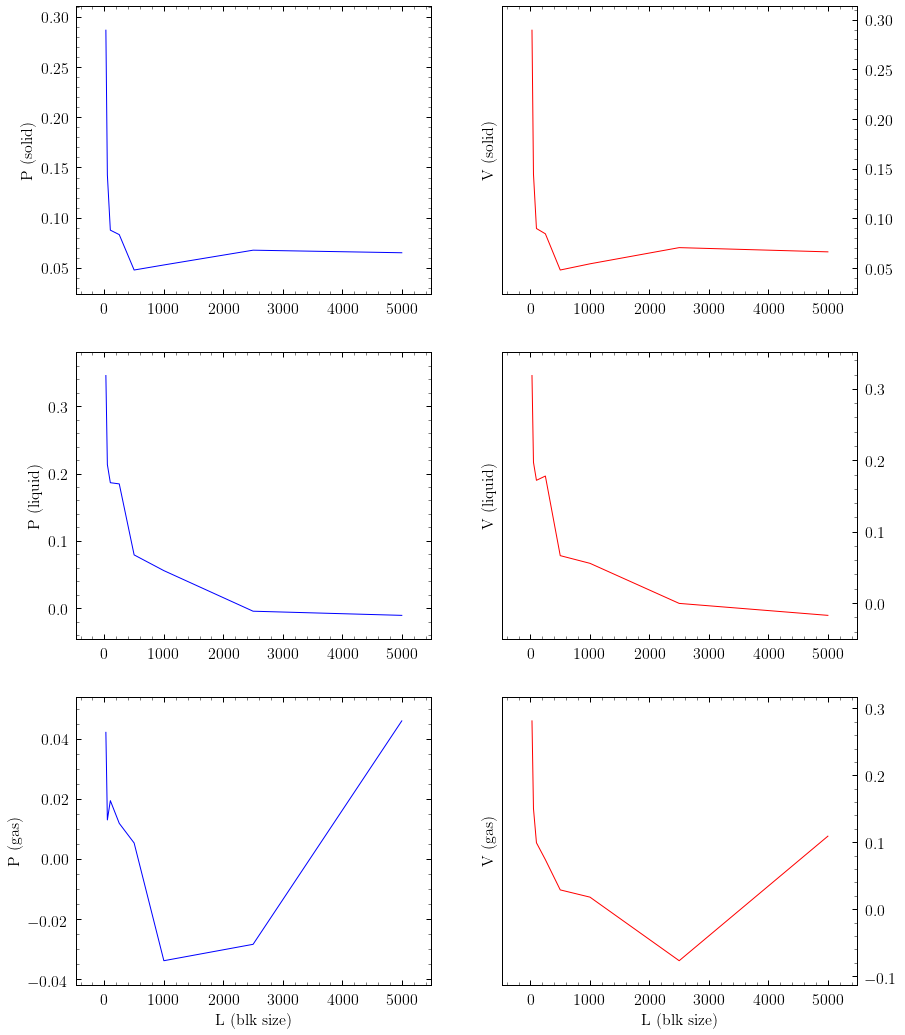

In [20]:
def p_incr(lista):
    appo = [lista[0]]
    for i in range(len(lista)-1):
        appo.append((lista[i+1] - lista[i])/lista[i])
    return appo

for state in states:
    df[state] = dict()
    for v in vv:
        df[state][v] = pd.read_csv(f"{v}-{state}-blk-evo.csv", header=None, sep=',', names=[v,'e'])[:-1]

fig, ax = plt.subplots(3, 2, figsize=(14,18));

ax = np.asarray(ax)
ax.shape = (1,6)
ax = ax[0]

L = [10, 25, 50, 100, 250, 500, 1000, 2500, 5000]

ix=0
for state in states:
    for v in vv:
        ax[ix].plot(L[1:], p_incr(df[state][v]['e'])[1:], c=next(cc))
        ax[ix].yaxis.tick_right() if (ix+1) % 2 == 0 else 0
        ax[ix].set_ylabel(f"{v} ({state})")
        ix += 1
        
ax[4].set_xlabel("L (blk size)");
ax[5].set_xlabel("L (blk size)");

## Excercise 07.1.3

## Exercise 07.4.1

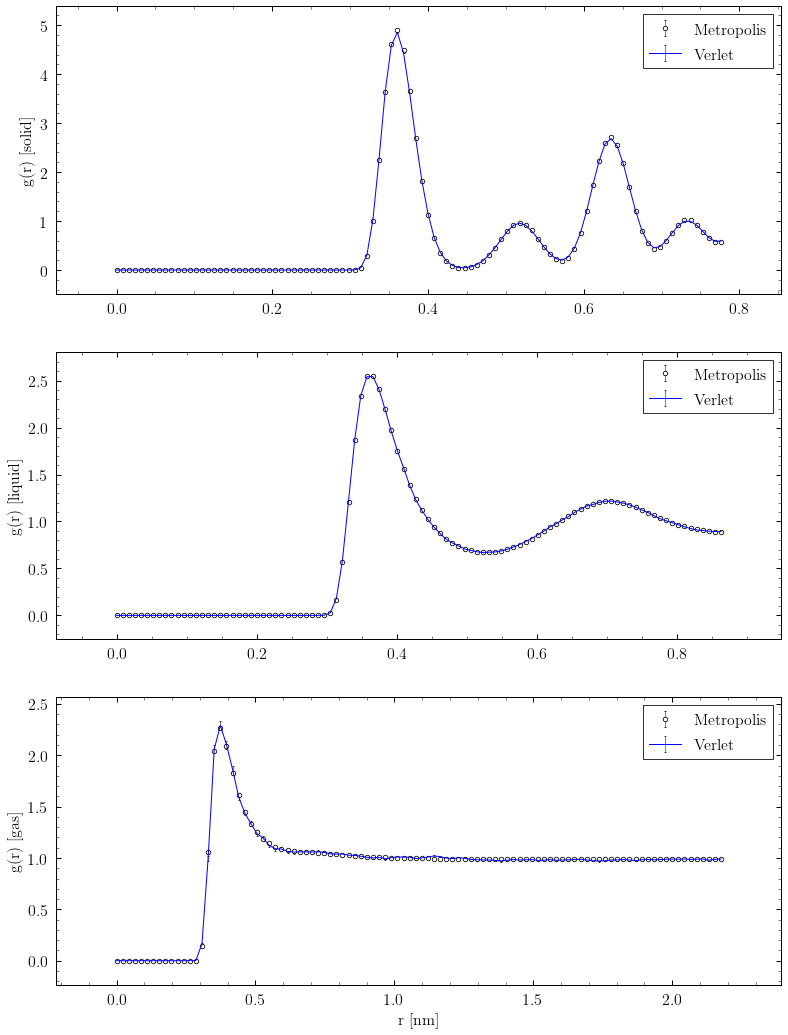

In [34]:
df = dict()
dft = dict()
SI = 0.34 # \sigma nm

for state in states:
    df[state] = pd.read_csv(f"gr-{state}-blk.csv", header=None, names=['r','v','e'])
    dft[state] = pd.read_csv(f"gr-{state}-verlet-blk.csv", header=None, names=['r','v','e'])
    
fig, ax = plt.subplots(3, 1, figsize=(13,18));    

for ix, state in enumerate(states):
    ax[ix].errorbar(df[state]['r']*SI, df[state]['v'], yerr=df[state]['e'], ls='', ecolor='gray', marker='.', ms=9, mfc='w', mec='k', mew=0.8, capthick=0.1, label='Metropolis')
    ax[ix].errorbar(dft[state]['r']*SI, dft[state]['v'], yerr=dft[state]['e'], c='b', ecolor='gray', marker=None, capthick=0.7, label='Verlet')
    ax[ix].set_ylabel(f'g(r) [{state}]', fontsize='medium')
    ax[ix].legend();
    
ax[2].set_xlabel('r [nm]', fontsize='medium');

## Excercise 07.4.2

Importing `*-solid-blk.csv` `*-liquid-blk.csv` `*-gas-blk.csv` and plot using SI

In [24]:
df = dict()
ee = 120 * 1.3806488e-23  # J energy
SI = {'V': ee*((1.602176565e-19)**-1)*(10**3), 'P': ee/(0.34e-9)**3}

for state in states:
    df[state] = dict()
    for v in vv:
        df[state][v] = pd.read_csv(f"{v}-{state}-blk.csv", header=None, names=['v','e'])
        df[state][v] = df[state][v]*SI[v]

### Solid Argon

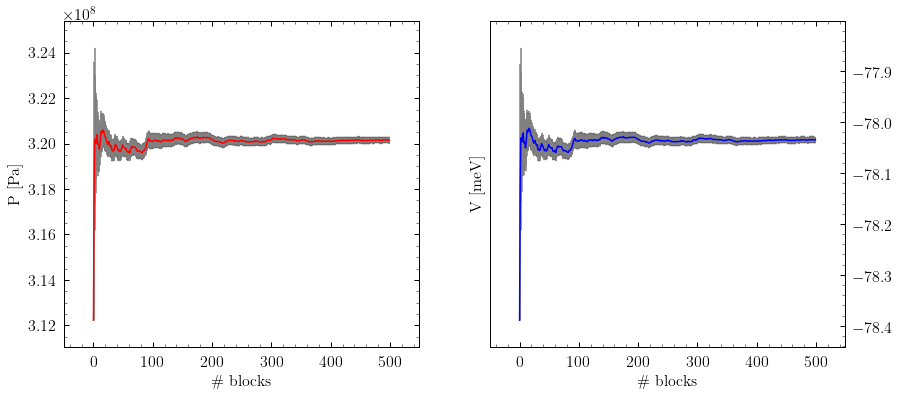

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(14,6));

ax = np.asarray(ax)
ax.shape = (1,2)
ax = ax[0]

for ix, v in enumerate(vv):
    df["solid"][v]['v'].plot.line(yerr=df["solid"][v]['e'], color=next(cc), lw=1.5, ecolor='gray', capthick=0.1, ax=ax[ix]);
    ax[ix].set_ylabel(f"{v} [Pa]") if (ix == 0) else ax[ix].set_ylabel(f"{v}  [meV]")
    ax[ix].yaxis.tick_right() if (ix == 1 or ix == 3) else 0
    ax[ix].set_xlabel('\# blocks')

### Liquid Argon

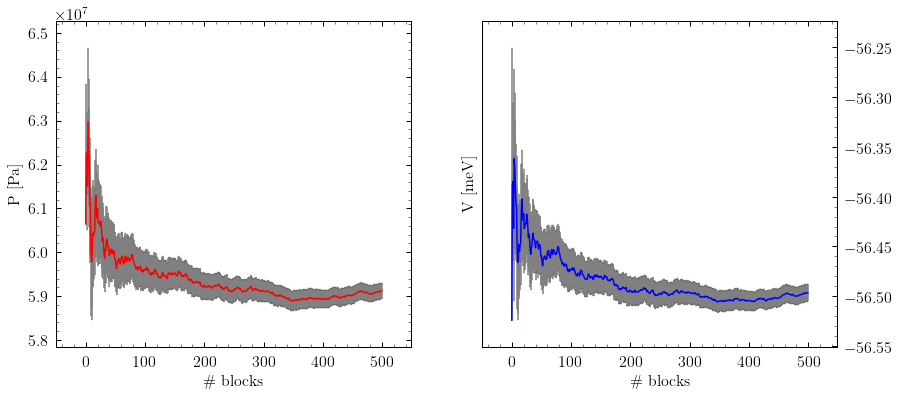

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(14,6));

ax = np.asarray(ax)
ax.shape = (1,2)
ax = ax[0]

for ix, v in enumerate(vv):
    df["liquid"][v]['v'].plot.line(yerr=df["liquid"][v]['e'], color=next(cc), lw=1.5, ecolor='gray', capthick=0.1, ax=ax[ix]);
    ax[ix].set_ylabel(f"{v} [Pa]") if (ix == 0) else ax[ix].set_ylabel(f"{v}  [meV]")
    ax[ix].yaxis.tick_right() if (ix == 1 or ix == 3) else 0
    ax[ix].set_xlabel('\# blocks')

### Gas Argon

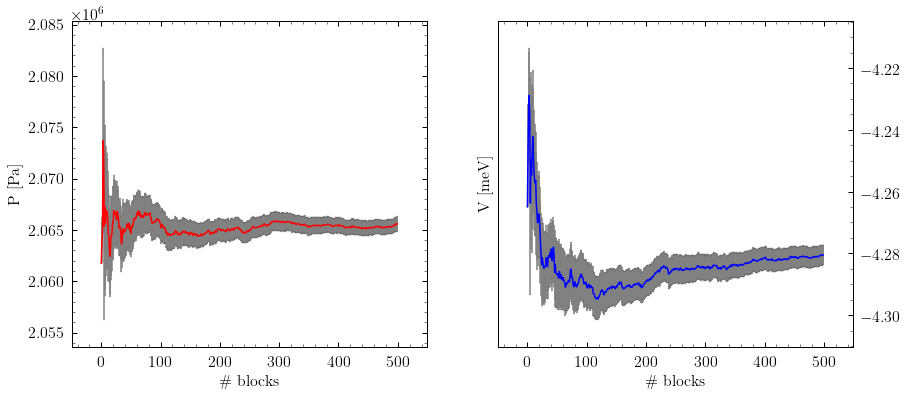

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(14,6));

ax = np.asarray(ax)
ax.shape = (1,2)
ax = ax[0]

for ix, v in enumerate(vv):
    df["gas"][v]['v'].plot.line(yerr=df["gas"][v]['e'], color=next(cc), lw=1.5, ecolor='gray', capthick=0.1, ax=ax[ix]);
    ax[ix].set_ylabel(f"{v} [Pa]") if (ix == 0) else ax[ix].set_ylabel(f"{v}  [meV]")
    ax[ix].yaxis.tick_right() if (ix == 1 or ix == 3) else 0
    ax[ix].set_xlabel('\# blocks')

ax[0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))